In [15]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

We have 2 banners promoting a new sport club.
The first banner is aggressive: it focuses on the weight equipment we have and is very attractive to crossfitters, but completely can't convince runners. Another one makes the main focus on the cardio trainers we have and is much more attractive for runners. The neutral banner is also attractive to crossfitters, but it's not so cool as the first one.

Actually we don't know it. But that's what designers kept in mind when they create those banners.

Also let's imaging we don't know web site visitors interests. And ideally we show just one banner which is "the best" in general.

Let's define the world model. And use it further as a black box. Use bernoulli instead of binomial to make everything transparent.

In [9]:
crossfitters_ratio = .48

aggressive = {"crossfitters": .68, "runners": .04}
neutral = {"crossfitters": .28, "runners": .4}

def test_banner(banner, shows):
    runners_dist = stats.bernoulli(banner["runners"])
    crossfitters_dist = stats.bernoulli(banner["crossfitters"])

    crossfitters_cnt = stats.bernoulli(crossfitters_ratio).rvs(shows).sum()
    runners_cnt = shows - crossfitters_cnt

    crossfitters_hits = crossfitters_dist.rvs(crossfitters_cnt).sum()
    runners_hits = runners_dist.rvs(runners_cnt).sum()
    
    return crossfitters_hits + runners_hits

To decide which banner is better we run experiment. We show both banners to random clients and make the conclusions out of the data we get.

Imagine we ran an experiment and computed the Convertion Rate as #Convertions / #Shows. That's a point estimation = 💩

To make some statistically significant conclusions we need to use confidence intervals or hypothesis checking methods.

Let's simplify everything a bit and sample from the true distribution directly. On practice we usually can't afford it and use bootstraping (delta-method/etc), but since we have the world model we don't need bootstrap.

CPU times: user 3.31 s, sys: 36.6 ms, total: 3.34 s
Wall time: 3.48 s


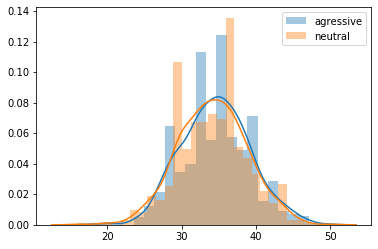

In [10]:
%%time
revenue_agressive = [test_banner(aggressive, 100) for _ in range(1000)]
revenue_neutral = [test_banner(neutral, 100) for _ in range(1000)]
sns.distplot(revenue_agressive, label="agressive")
sns.distplot(revenue_neutral, label="neutral")
plt.legend()

CPU times: user 3.46 s, sys: 25.5 ms, total: 3.49 s
Wall time: 3.55 s


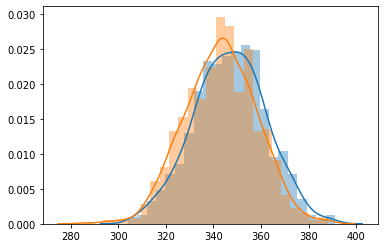

In [11]:
%%time
revenue_agressive = [test_banner(aggressive, 1000) for _ in range(1000)]
revenue_neutral = [test_banner(neutral, 1000) for _ in range(1000)]
sns.distplot(revenue_agressive)
sns.distplot(revenue_neutral)

CPU times: user 12.3 s, sys: 136 ms, total: 12.5 s
Wall time: 13.1 s


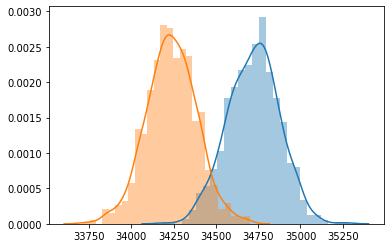

In [12]:
%%time
revenue_agressive = [test_banner(aggressive, 100000) for _ in range(1000)]
revenue_neutral = [test_banner(neutral, 100000) for _ in range(1000)]

sns.distplot(revenue_agressive)
sns.distplot(revenue_neutral)

CPU times: user 1min 29s, sys: 2.69 s, total: 1min 32s
Wall time: 1min 33s


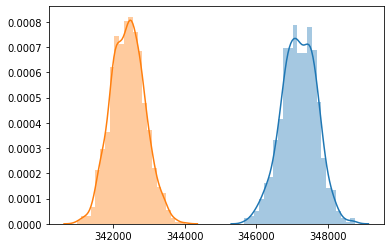

In [13]:
%%time
revenue_agressive = [test_banner(aggressive, 1000000) for _ in range(1000)]
revenue_neutral = [test_banner(neutral, 1000000) for _ in range(1000)]

sns.distplot(revenue_agressive)
sns.distplot(revenue_neutral)

**Regret** - the money we lost on an experiment. If we have a magic oracle that tells you which banner is the best without any experiments you save ~ 347k - 343k = 4k €

You also may compute regret in counts of the "bad" banner shows. The loss in each show is the same. So, regret is 1M shows.

Due to we know how the real world behaves, let's check which banner is actually better.

In [56]:
.48 * .68 + .52 * .04, .48 * .28 + .52 * .4

(0.3472, 0.34240000000000004)

Usually you have too many factors and it's hard to say if two banners have real different conversion rate. The less difference the more audience you need to find the difference.

So, you want to have some early stopping method + the tool to compare more than 2 banners the same time.

There are some tools in classis statistics. But they look overcomplicated compared to the following approach. The other benefit of Multiarmed Bandits: you can use Contextual Multiarmed Bandits when you have additional information about users (gender, city, etc).

## Multiarmed bandit [Thompson sampling]

<img src="https://www.abtasty.com/content/uploads/img_5559fcc451925.png" width="200px" align="left"/>
<img src="https://vignette.wikia.nocookie.net/matrix/images/d/da/Spoon_Boy_Neo_Bends.jpg/revision/latest/scale-to-width-down/266?cb=20130119092916" width="200px" align="right"/>
CTR doesn't exist, but we have CTR distribution.

* In fact there is a distribution of our knowledge about CTR.

Let's assume CTR is a Beta distribution. <s>Because of conjugate prior</s> Because I like Beta distribution.

We don't know any supported by data prior knowledge about the true CTR. Therefore it's better to use non-informative prior than use some particular value.

Don't use prejudices/preconception as a prior. Use either non-informative prior or something supported by data. Otherwise you would be loosing money when the model would fix your prior belives with the data.

How the Beta distribution looks like.

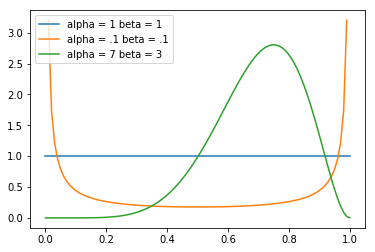

In [64]:
xs = np.linspace(0, 1, 100)
plt.plot(xs, stats.beta(1, 1).pdf(xs), label="alpha = 1 beta = 1")
plt.plot(xs, stats.beta(.1, .1).pdf(xs), label="alpha = .1 beta = .1")
plt.plot(xs, stats.beta(7, 3).pdf(xs), label="alpha = 7 beta = 3")
plt.legend()

$Pr(A|B) = \frac{Pr(B|A)Pr(A)}{Pr(B)}$

$X$ - events (click/no-click)

CTR is a distribution, obviously it's defined on [0,1] (dom of Beta distribution).

$Pr(CTR|X) = \frac{Pr(X|CTR)Pr(CTR)}{Pr(X)} = \frac{Binomial(CTR) * Beta(\alpha, \beta)}{\int{Binomial(CTR) * Beta(\alpha, \beta)}} = \frac{Bernoulli(CTR) * Beta(\alpha, \beta)}{Const}$


Beta: $\frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{\mathrm {B}(\alpha, \beta)}$ Binomial: $\binom{N}{k} p^k(1 - p)^{N - k}$, **where p is a success probability, which is distributed as Beta**

$
Pr(CTR|X) = (p^{(\alpha + k) - 1} (1 - p)^{(\beta + N - k) - 1}) / Const
$

It has a shape of Beta distribution: $p^{\alpha - 1} (1 - p)^{\beta - 1}$

$\alpha_{new} = \alpha + k$

$\beta_{new} = \beta + N - k$

But we don't know the normalization constant. This curve may lay upper or lower than Beta distribution curve with same parameters. But we know the posterior is a some distribution and the square under the line should be = 1. So the only possible option - the Pr(CTR|X) curve is exactly the Beta distribution with $\alpha_{new}$ and $\beta_{new}$ parameters.

**$\alpha$ & $\beta$ correspond to the number of successes / failures**

The more data we've seen the more confident we're in the estimation.

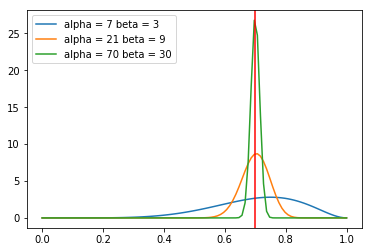

In [72]:
xs = np.linspace(0, 1, 100)
plt.plot(xs, stats.beta(7, 3).pdf(xs), label="alpha = 7 beta = 3")
plt.plot(xs, stats.beta(70, 30).pdf(xs), label="alpha = 21 beta = 9")
plt.plot(xs, stats.beta(700, 300).pdf(xs), label="alpha = 70 beta = 30")
plt.axvline(.7, 0, 1, color="red")
plt.legend()

### What banner to show

Let's create a lottery. On each show <s>sample</s> draw a dice out of Beta distribution and have a CTR point estimation.

In [17]:
crossfitters_ratio = .48

aggressive = {"crossfitters": .68, "runners": .04}
neutral = {"crossfitters": .28, "runners": .4}

agressive_beta = {"alpha": 1, "beta": 1}
neutral_beta = {"alpha": 1, "beta": 1}

regret = 0
revenue = 0
for _ in tqdm(range(2000000)):
    aggresive_score = stats.beta(agressive_beta["alpha"], agressive_beta["beta"]).rvs()
    neutral_score = stats.beta(neutral_beta["alpha"], neutral_beta["beta"]).rvs()
    user_type = "crossfitters" if stats.bernoulli(crossfitters_ratio).rvs() > 0 else "runners"
    if aggresive_score > neutral_score:
        click = stats.bernoulli(aggressive[user_type]).rvs()
        if click:
            agressive_beta["alpha"] += 1
        else:
            agressive_beta["beta"] += 1
    else:
        regret += 1
        click = stats.bernoulli(neutral[user_type]).rvs()
        if click:
            neutral_beta["alpha"] += 1
        else:
            neutral_beta["beta"] += 1
    revenue += click

In [18]:
regret, revenue

(33580, 693249)

In [19]:
agressive_beta, neutral_beta

({'alpha': 681856, 'beta': 1284566}, {'alpha': 11395, 'beta': 22187})

In [21]:
agressive_beta["alpha"] / (agressive_beta["alpha"] + agressive_beta["beta"]), neutral_beta["alpha"] / (neutral_beta["alpha"] + neutral_beta["beta"])

(0.34674957867639805, 0.3393186826275981)

In [24]:
crossfitters_ratio = .48

aggressive = {"crossfitters": .68, "runners": .04}
neutral = {"crossfitters": .28, "runners": .4}

agressive_beta = {"alpha": 1, "beta": 1}
neutral_beta = {"alpha": 1, "beta": 1}

regret = 0
revenue = 0
for _ in tqdm(range(200000)):
    aggresive_score = stats.beta(agressive_beta["alpha"], agressive_beta["beta"]).rvs()
    neutral_score = stats.beta(neutral_beta["alpha"], neutral_beta["beta"]).rvs()
    user_type = "crossfitters" if stats.bernoulli(crossfitters_ratio).rvs() > 0 else "runners"
    if aggresive_score > neutral_score:
        click = stats.bernoulli(aggressive[user_type]).rvs()
        if click:
            agressive_beta["alpha"] += 1
        else:
            agressive_beta["beta"] += 1
    else:
        regret += 1
        click = stats.bernoulli(neutral[user_type]).rvs()
        if click:
            neutral_beta["alpha"] += 1
        else:
            neutral_beta["beta"] += 1
    revenue += click

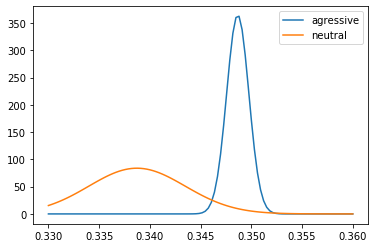

In [25]:
xs = np.linspace(0.33, 0.36, 100)
plt.plot(xs, stats.beta(agressive_beta["alpha"], agressive_beta["beta"]).pdf(xs), label="agressive")
plt.plot(xs, stats.beta(neutral_beta["alpha"], neutral_beta["beta"]).pdf(xs), label="neutral")
plt.legend()

In [26]:
regret, revenue

(9896, 69634)

In [27]:
agressive_beta, neutral_beta

({'alpha': 66283, 'beta': 123823}, {'alpha': 3353, 'beta': 6545})

In [28]:
agressive_beta["alpha"] / (agressive_beta["alpha"] + agressive_beta["beta"]), neutral_beta["alpha"] / (neutral_beta["alpha"] + neutral_beta["beta"])

(0.3486633772737315, 0.33875530410183874)

### So, why are we using Beta as a prior

We assume there is a true CTR and we have a distribution of our belief in CTR. Therefore this distribution should converge to delta-function. And have a domain of [0,1]. Beta satisfies these properties and is computational effecient.